# 🎯 ML Para Decisão de Protesto - V3 Final

## Objetivo do Modelo
Prever se, ao **PROTESTAR** um cliente, ele vai **PAGAR** a dívida.

## Contexto
- Dataset contém clientes que **JÁ FORAM PROTESTADOS**
- **Classe 1 (Pagos TMB)**: Cliente PAGOU após ser protestado → **VALE PROTESTAR**
- **Classe 0 (Não foram pagos)**: Cliente NÃO PAGOU mesmo protestado → **NÃO VALE PROTESTAR**

## Lógica de Custos
- **Protestar quem NÃO vai pagar (FP)**: Custo alto (tempo + recursos desperdiçados)
- **Não protestar quem ia pagar (FN)**: Custo de oportunidade (perda de recuperação)

## 🎯 FOCO: Alta PRECISION
Quando decidimos protestar, queremos acertar!

In [49]:
# ==============================================================================
# 0. IMPORTAÇÕES E CONFIGURAÇÕES GLOBAIS
# ==============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import inflection
import joblib
import warnings
import os
from datetime import datetime
from pathlib import Path

# Pré-processamento e Pipeline
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline as SklearnPipeline
from imblearn.pipeline import Pipeline as ImblearnPipeline
from imblearn.combine import SMOTETomek

# Modelos
import xgboost as xgb
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# Otimização e Calibração
from skopt import BayesSearchCV
from skopt.space import Real, Integer
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

# Métricas de Avaliação
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix, f1_score,
    roc_auc_score, precision_score, recall_score, average_precision_score,
    precision_recall_curve
)

# Configurações
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 7)
pd.set_option('display.max_columns', None)

print("✅ Bibliotecas importadas com sucesso!")

✅ Bibliotecas importadas com sucesso!


In [50]:
# ==============================================================================
# 1. CONFIGURAÇÕES PRINCIPAIS
# ==============================================================================

# Arquivos de dados
DATA_FILE_PATH = 'train.xlsx'
TEST_FILE_PATH = 'test.csv'



# ⚙️ CONFIGURAÇÃO: Escolha quais categorias rodar
# Opções: ['Baixo'], ['Medio'], ['Alto'], ['Baixo', 'Medio', 'Alto'] (todas)
CATEGORIAS_PARA_RODAR = ['Baixo', 'Médio', 'Alto']  # Rode TODAS as categorias

# CUSTOS DE NEGÓCIO
CUSTO_FALSO_POSITIVO = 3.0  # Protestar quem NÃO vai pagar (alto)
CUSTO_FALSO_NEGATIVO = 1.0  # Não protestar quem iria pagar (menor)

# Diretório de saída
RUN_DATE = datetime.now().strftime('%Y%m%d_%H%M%S')
BASE_OUTPUT_DIR = Path(f'v3_runs/run_{RUN_DATE}')
BASE_OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

print("=" * 80)
print("🎯 ML PARA DECISÃO DE PROTESTO - V3 FINAL")
print("   Objetivo: Prever quem vai PAGAR se for PROTESTADO")
print("=" * 80)
print(f"\n📊 Categorias para rodar: {CATEGORIAS_PARA_RODAR}")
print(f"📁 Arquivo de treino: {DATA_FILE_PATH}")
print(f"📁 Arquivo de teste: {TEST_FILE_PATH}")
print(f"💰 Custo FP (protestar errado): {CUSTO_FALSO_POSITIVO}")
print(f"💰 Custo FN (deixar de protestar): {CUSTO_FALSO_NEGATIVO}")
print(f"📂 Diretório de saída: {BASE_OUTPUT_DIR}")

🎯 ML PARA DECISÃO DE PROTESTO - V3 FINAL
   Objetivo: Prever quem vai PAGAR se for PROTESTADO

📊 Categorias para rodar: ['Baixo', 'Médio', 'Alto']
📁 Arquivo de treino: train.xlsx
📁 Arquivo de teste: test.csv
💰 Custo FP (protestar errado): 3.0
💰 Custo FN (deixar de protestar): 1.0
📂 Diretório de saída: v3_runs/run_20251127_144539


In [51]:
# ==============================================================================
# 2. FUNÇÕES DE PREPARAÇÃO DE DADOS
# ==============================================================================

def load_data_excel(file_path):
    """Carrega os dados do arquivo Excel."""
    print(f"\n>>> Carregando dados de: {file_path}")
    df = pd.read_excel(file_path)
    print(f"    Shape inicial: {df.shape}")
    return df

def load_data_csv(file_path, separator=';'):
    """Carrega os dados do arquivo CSV."""
    print(f"\n>>> Carregando dados de: {file_path}")
    df = pd.read_csv(file_path, sep=separator)
    print(f"    Shape inicial: {df.shape}")
    return df

def clean_column_names(df):
    """Padroniza os nomes das colunas para snake_case."""
    df_copy = df.copy()
    df_copy.columns = [inflection.underscore(c).strip().replace(' ', '_').replace('__', '_') 
                       for c in df_copy.columns]
    return df_copy

def clean_monetary_columns(df):
    """Limpa e converte colunas monetárias para float."""
    df_clean = df.copy()
    
    monetary_cols = [
        'total_financiado', 'saldo_vencido', 'recebido', 
        'saldo_vencido_com_juros', 'total_pago_com_juros', 
        'vencidos_sem_juros_tmb', 'recebido_sem_juros_tmb'
    ]
    
    for col in monetary_cols:
        if col in df_clean.columns:
            df_clean[col] = df_clean[col].astype(str)
            df_clean[col] = (df_clean[col]
                           .str.replace('R$', '', regex=False)
                           .str.replace('.', '', regex=False)
                           .str.replace(',', '.', regex=False)
                           .str.strip())
            df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')
    
    return df_clean

def prepare_target(df, target_col='pagamento'):
    """Prepara a variável alvo (se existir)."""
    df_copy = df.copy()
    
    if target_col not in df_copy.columns:
        print(f"    ⚠️ Coluna '{target_col}' não encontrada. Dados sem target (teste).")
        return df_copy
    
    df_copy[target_col] = df_copy[target_col].astype(str).str.strip()
    df_copy[target_col] = df_copy[target_col].replace('Pago no Cartório', 'Pagos TMB')
    
    valid_values = ['Pagos TMB', 'Não foram pagos']
    df_copy = df_copy[df_copy[target_col].isin(valid_values)]
    
    # Classe 1 = Pagou (vale protestar), Classe 0 = Não pagou (não vale protestar)
    df_copy['target'] = (df_copy[target_col] == 'Pagos TMB').astype(int)
    
    print(f"\n📊 Distribuição do Target:")
    print(f"    Classe 0 (Não pagou): {(df_copy['target']==0).sum()} ({(df_copy['target']==0).mean():.1%})")
    print(f"    Classe 1 (Pagou):     {(df_copy['target']==1).sum()} ({(df_copy['target']==1).mean():.1%})")
    
    return df_copy

print("✅ Funções de preparação de dados definidas.")

✅ Funções de preparação de dados definidas.


In [52]:
# ==============================================================================
# 3. ENGENHARIA DE FEATURES
# ==============================================================================

def engineer_features(df):
    """
    Engenharia de features para predição de pagamento após protesto.
    """
    print("\n>>> Executando engenharia de features...")
    df_eng = df.copy()
    
    # --- 0. CORREÇÃO DE TIPOS ---
    if 'pdd' in df_eng.columns:
        df_eng['pdd'] = df_eng['pdd'].astype(str)
    
    # --- 1. FEATURES DE SCORE E IDADE ---
    df_eng['score_x_idade'] = df_eng['score'] * df_eng['idade']
    df_eng['score_ao_quadrado'] = df_eng['score'] ** 2
    df_eng['score_por_idade'] = df_eng['score'] / (df_eng['idade'] + 1)
    
    # Faixa etária
    df_eng['faixa_etaria'] = pd.cut(
        df_eng['idade'], 
        bins=[0, 25, 35, 45, 55, 65, 120], 
        labels=['18-25', '26-35', '36-45', '46-55', '56-65', '65+']
    ).astype(str)
    
    # Faixa de score
    df_eng['faixa_score'] = pd.cut(
        df_eng['score'],
        bins=[0, 300, 500, 700, 850, 1000],
        labels=['Muito_Baixo', 'Baixo', 'Medio', 'Bom', 'Excelente']
    ).astype(str)
    
    # --- 2. FEATURES GEOGRÁFICAS ---
    mapa_regioes = {
        'AC': 'Norte', 'AP': 'Norte', 'AM': 'Norte', 'PA': 'Norte', 
        'RO': 'Norte', 'RR': 'Norte', 'TO': 'Norte',
        'AL': 'Nordeste', 'BA': 'Nordeste', 'CE': 'Nordeste', 'MA': 'Nordeste', 
        'PB': 'Nordeste', 'PE': 'Nordeste', 'PI': 'Nordeste', 'RN': 'Nordeste', 'SE': 'Nordeste',
        'DF': 'Centro-Oeste', 'GO': 'Centro-Oeste', 'MT': 'Centro-Oeste', 'MS': 'Centro-Oeste',
        'ES': 'Sudeste', 'MG': 'Sudeste', 'RJ': 'Sudeste', 'SP': 'Sudeste',
        'PR': 'Sul', 'RS': 'Sul', 'SC': 'Sul'
    }
    
    if 'endereco_estado' in df_eng.columns:
        df_eng['regiao'] = df_eng['endereco_estado'].str.upper().str.strip().map(mapa_regioes).fillna('Outra')
    else:
        df_eng['regiao'] = 'Desconhecido'
    
    # --- 3. FEATURES FINANCEIRAS ---
    df_eng['valor_medio_parcela'] = np.where(
        df_eng['quantidade_parcelas'] > 0,
        df_eng['total_financiado'] / df_eng['quantidade_parcelas'],
        0
    )
    
    df_eng['percentual_vencido'] = np.where(
        df_eng['total_financiado'] > 0,
        df_eng['saldo_vencido'] / df_eng['total_financiado'],
        0
    )
    
    df_eng['percentual_pago'] = np.where(
        df_eng['total_financiado'] > 0,
        df_eng['recebido'] / df_eng['total_financiado'],
        0
    )
    
    df_eng['percentual_parcelas_vencidas'] = np.where(
        df_eng['quantidade_parcelas'] > 0,
        df_eng['quantidade_parcelas_vencidas'] / df_eng['quantidade_parcelas'],
        0
    )
    
    # Severidade do atraso
    df_eng['severidade_atraso'] = df_eng['dias_em_atraso'] * df_eng['percentual_vencido']
    
    # --- 4. INDICADORES BINÁRIOS ---
    df_eng['ja_pagou_algo'] = (df_eng['recebido'] > 0).astype(int)
    df_eng['atraso_severo'] = (df_eng['dias_em_atraso'] > 90).astype(int)
    df_eng['alto_comprometimento'] = (df_eng['percentual_vencido'] > 0.5).astype(int)
    
    # --- 5. FEATURES DE INTERAÇÃO ---
    df_eng['score_x_percentual_pago'] = df_eng['score'] * df_eng['percentual_pago']
    df_eng['score_x_atraso'] = df_eng['score'] / (df_eng['dias_em_atraso'] + 1)
    
    # --- 6. LOG DE VALORES MONETÁRIOS ---
    df_eng['total_financiado_log'] = np.log1p(df_eng['total_financiado'].clip(lower=0))
    df_eng['saldo_vencido_log'] = np.log1p(df_eng['saldo_vencido'].clip(lower=0))
    
    # --- 7. LIMPEZA FINAL ---
    df_eng.replace([np.inf, -np.inf], np.nan, inplace=True)
    
    numeric_cols = df_eng.select_dtypes(include=np.number).columns
    df_eng[numeric_cols] = df_eng[numeric_cols].fillna(0)
    
    object_cols = df_eng.select_dtypes(include=['object']).columns
    df_eng[object_cols] = df_eng[object_cols].fillna('Desconhecido')
    
    print(f"    ✅ Features criadas. Shape final: {df_eng.shape}")
    
    return df_eng

print("✅ Função de engenharia de features definida.")

✅ Função de engenharia de features definida.


In [53]:
# ==============================================================================
# 4. DEFINIÇÃO DAS FEATURES E PREPROCESSAMENTO
# ==============================================================================

# Features numéricas
NUMERIC_FEATURES = [
    'score', 'idade', 'total_financiado', 'quantidade_parcelas', 'saldo_vencido',
    'quantidade_parcelas_vencidas', 'dias_em_atraso',
    'score_x_idade', 'score_ao_quadrado', 'score_por_idade',
    'valor_medio_parcela', 'percentual_vencido', 'percentual_pago',
    'percentual_parcelas_vencidas', 'severidade_atraso',
    'ja_pagou_algo', 'atraso_severo', 'alto_comprometimento',
    'score_x_percentual_pago', 'score_x_atraso',
    'total_financiado_log', 'saldo_vencido_log'
]

# Features categóricas
CATEGORICAL_FEATURES = [
    'status_cobranca', 'faixa_etaria', 'faixa_score', 'regiao', 
    'segmento', 'categoria_risco_score', 'modalidade', 'pdd'
]

def create_preprocessor(numeric_features, categorical_features):
    """Cria o pré-processador para o pipeline."""
    
    numeric_transformer = SklearnPipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])
    
    categorical_transformer = SklearnPipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='Desconhecido')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False, min_frequency=0.01))
    ])
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ],
        remainder='drop'
    )
    
    return preprocessor

print("✅ Features e preprocessamento definidos.")

✅ Features e preprocessamento definidos.


In [54]:
# ==============================================================================
# 5. FUNÇÕES DE THRESHOLD E AVALIAÇÃO
# ==============================================================================

def find_optimal_threshold(y_true, y_proba, custo_fp=3.0, custo_fn=1.0):
    """
    Encontra o threshold ótimo para decisão de protesto.
    
    O threshold define: se probabilidade >= threshold, PROTESTAR
    
    - Threshold ALTO = mais conservador, protesta menos, menos FP
    - Threshold BAIXO = mais agressivo, protesta mais, menos FN
    """
    thresholds = np.arange(0.10, 0.90, 0.01)
    best_threshold = 0.5
    min_cost = float('inf')
    
    results = []
    for thresh in thresholds:
        y_pred = (y_proba >= thresh).astype(int)
        
        fp = np.sum((y_true == 0) & (y_pred == 1))  # Protestou errado
        fn = np.sum((y_true == 1) & (y_pred == 0))  # Deixou de protestar
        tp = np.sum((y_true == 1) & (y_pred == 1))  # Protestou certo
        tn = np.sum((y_true == 0) & (y_pred == 0))  # Não protestou certo
        
        total_cost = (fp * custo_fp) + (fn * custo_fn)
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
        
        results.append({
            'threshold': thresh, 'cost': total_cost,
            'precision': precision, 'recall': recall, 'f1': f1,
            'tp': tp, 'fp': fp, 'tn': tn, 'fn': fn
        })
        
        if total_cost < min_cost:
            min_cost = total_cost
            best_threshold = thresh
    
    return best_threshold, min_cost, pd.DataFrame(results)

def evaluate_model(y_true, y_pred, y_proba, model_name="Model"):
    """Avalia o modelo com métricas focadas em decisão de protesto."""
    
    metrics = {
        'accuracy': accuracy_score(y_true, y_pred),
        'f1': f1_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred),
        'recall': recall_score(y_true, y_pred),
        'roc_auc': roc_auc_score(y_true, y_proba),
        'avg_precision': average_precision_score(y_true, y_proba)
    }
    
    print(f"\n📊 Métricas - {model_name}:")
    print(f"    Accuracy:     {metrics['accuracy']:.4f}")
    print(f"    F1-Score:     {metrics['f1']:.4f}")
    print(f"    🎯 PRECISION: {metrics['precision']:.4f} ← Assertividade do protesto")
    print(f"    📈 RECALL:    {metrics['recall']:.4f} ← Cobertura de pagadores")
    print(f"    ROC-AUC:      {metrics['roc_auc']:.4f}")
    print(f"    Avg Precision:{metrics['avg_precision']:.4f}")
    
    return metrics

print("✅ Funções de avaliação definidas.")

✅ Funções de avaliação definidas.


In [55]:
# ==============================================================================
# 6. FUNÇÕES DE SALVAMENTO DE RELATÓRIOS
# ==============================================================================

def save_metrics_report(output_dir, categoria, metrics, cm, threshold, y_test, y_pred, 
                        training_time, best_params, model_name, extra_info=None):
    """Salva relatório completo de métricas em arquivo TXT."""
    
    report_path = output_dir / f"relatorio_metricas_{categoria}.txt"
    
    TN, FP, FN, TP = cm.ravel()
    total = TN + FP + FN + TP
    
    with open(report_path, 'w', encoding='utf-8') as f:
        f.write("=" * 80 + "\n")
        f.write(f"📊 RELATÓRIO DE MÉTRICAS - CATEGORIA: {categoria.upper()}\n")
        f.write("=" * 80 + "\n")
        f.write(f"Data/Hora: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
        f.write(f"Modelo: {model_name}\n")
        f.write(f"Tempo de Treinamento: {training_time:.2f} segundos\n")
        f.write("\n")
        
        f.write("-" * 40 + "\n")
        f.write("MÉTRICAS DE DESEMPENHO\n")
        f.write("-" * 40 + "\n")
        f.write(f"Accuracy:         {metrics['accuracy']:.4f} ({metrics['accuracy']:.2%})\n")
        f.write(f"F1-Score:         {metrics['f1']:.4f} ({metrics['f1']:.2%})\n")
        f.write(f"🎯 PRECISION:     {metrics['precision']:.4f} ({metrics['precision']:.2%})\n")
        f.write(f"📈 RECALL:        {metrics['recall']:.4f} ({metrics['recall']:.2%})\n")
        f.write(f"ROC-AUC:          {metrics['roc_auc']:.4f} ({metrics['roc_auc']:.2%})\n")
        f.write(f"Avg Precision:    {metrics['avg_precision']:.4f} ({metrics['avg_precision']:.2%})\n")
        f.write("\n")
        
        f.write("-" * 40 + "\n")
        f.write("THRESHOLD OTIMIZADO\n")
        f.write("-" * 40 + "\n")
        f.write(f"Threshold Ótimo:  {threshold:.2f}\n")
        f.write(f"Custo FP:         {CUSTO_FALSO_POSITIVO}\n")
        f.write(f"Custo FN:         {CUSTO_FALSO_NEGATIVO}\n")
        f.write("\n")
        
        f.write("-" * 40 + "\n")
        f.write("MATRIZ DE CONFUSÃO\n")
        f.write("-" * 40 + "\n")
        f.write(f"                    PREDITO\n")
        f.write(f"                NÃO Prot.  PROTESTAR\n")
        f.write(f"REAL NÃO Pagou     {TN:5d}      {FP:5d}\n")
        f.write(f"     PAGOU         {FN:5d}      {TP:5d}\n")
        f.write("\n")
        f.write(f"Total de amostras: {total}\n")
        f.write("\n")
        
        f.write("-" * 40 + "\n")
        f.write("ANÁLISE DE DECISÃO DE PROTESTO\n")
        f.write("-" * 40 + "\n")
        f.write(f"Total de clientes:           {total}\n")
        f.write(f"Decisão PROTESTAR:           {TP + FP} ({(TP + FP)/total:.1%})\n")
        f.write(f"Decisão NÃO Protestar:       {TN + FN} ({(TN + FN)/total:.1%})\n")
        f.write("\n")
        f.write(f"Quando PROTESTAMOS ({TP + FP} clientes):\n")
        f.write(f"  • {TP} vão PAGAR (TP) → Recuperação de dívida! ✅\n")
        f.write(f"  • {FP} NÃO vão pagar (FP) → Desperdício de recursos ❌\n")
        f.write(f"  → Taxa de sucesso: {TP/(TP+FP):.1%}\n")
        f.write("\n")
        f.write(f"Quando NÃO protestamos ({TN + FN} clientes):\n")
        f.write(f"  • {TN} realmente não pagariam (TN) → Economia! ✅\n")
        f.write(f"  • {FN} teriam pago (FN) → Oportunidade perdida ❌\n")
        f.write("\n")
        
        f.write("-" * 40 + "\n")
        f.write("MELHORES HIPERPARÂMETROS\n")
        f.write("-" * 40 + "\n")
        for param, value in best_params.items():
            f.write(f"{param}: {value}\n")
        f.write("\n")
        
        f.write("-" * 40 + "\n")
        f.write("RELATÓRIO DE CLASSIFICAÇÃO\n")
        f.write("-" * 40 + "\n")
        f.write(classification_report(y_test, y_pred, target_names=['NÃO Protestar', 'PROTESTAR']))
        
        if extra_info:
            f.write("\n")
            f.write("-" * 40 + "\n")
            f.write("INFORMAÇÕES ADICIONAIS\n")
            f.write("-" * 40 + "\n")
            for key, value in extra_info.items():
                f.write(f"{key}: {value}\n")
    
    print(f"    ✅ Relatório salvo em: {report_path}")
    return report_path

def save_summary_md(output_dir, all_results):
    """Salva resumo geral em Markdown."""
    
    summary_path = output_dir / "RESUMO_GERAL.md"
    
    with open(summary_path, 'w', encoding='utf-8') as f:
        f.write("# 📊 Resumo Geral - ML Protesto V3\n\n")
        f.write(f"**Data/Hora:** {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n\n")
        f.write("## Configurações\n\n")
        f.write(f"- **Custo FP:** {CUSTO_FALSO_POSITIVO}\n")
        f.write(f"- **Custo FN:** {CUSTO_FALSO_NEGATIVO}\n\n")
        
        f.write("## Resultados por Categoria\n\n")
        f.write("| Categoria | Modelo | F1-Score | Precision | Recall | ROC-AUC | Threshold |\n")
        f.write("|-----------|--------|----------|-----------|--------|---------|----------|\n")
        
        for result in all_results:
            f.write(f"| {result['categoria']} | {result['model_name']} | ")
            f.write(f"{result['metrics']['f1']:.4f} | {result['metrics']['precision']:.4f} | ")
            f.write(f"{result['metrics']['recall']:.4f} | {result['metrics']['roc_auc']:.4f} | ")
            f.write(f"{result['threshold']:.2f} |\n")
        
        f.write("\n## Análise de Decisão de Protesto\n\n")
        
        for result in all_results:
            cm = result['confusion_matrix']
            TN, FP, FN, TP = cm.ravel()
            total = TN + FP + FN + TP
            
            f.write(f"### {result['categoria']}\n\n")
            f.write(f"- **Total de clientes:** {total}\n")
            f.write(f"- **Decisão PROTESTAR:** {TP + FP} ({(TP + FP)/total:.1%})\n")
            f.write(f"- **Decisão NÃO Protestar:** {TN + FN} ({(TN + FN)/total:.1%})\n")
            f.write(f"- **Taxa de sucesso do protesto:** {TP/(TP+FP):.1%}\n\n")
    
    print(f"✅ Resumo geral salvo em: {summary_path}")
    return summary_path

print("✅ Funções de salvamento definidas.")

✅ Funções de salvamento definidas.


In [56]:
# ==============================================================================
# 7. FUNÇÃO PRINCIPAL DE TREINAMENTO
# ==============================================================================

def train_category(df_raw, categoria, output_dir):
    """
    Treina modelo para uma categoria específica de risco.
    """
    import time
    start_time = time.time()
    
    print("\n" + "=" * 80)
    print(f"🚀 TREINANDO CATEGORIA: {categoria.upper()}")
    print("=" * 80)
    
    # Cria diretório específico para a categoria
    cat_output_dir = output_dir / categoria.lower()
    cat_output_dir.mkdir(parents=True, exist_ok=True)
    
    # Filtra dados pela categoria
    df = df_raw[df_raw['categoria_risco_score'] == categoria].copy()
    print(f"\n>>> Registros para categoria '{categoria}': {len(df)}")
    
    if len(df) < 100:
        print(f"    ⚠️ Poucos dados para categoria '{categoria}'. Pulando...")
        return None
    
    # Prepara dados
    df = clean_column_names(df)
    df = clean_monetary_columns(df)
    df = prepare_target(df)
    df = engineer_features(df)
    
    # Filtra idades válidas
    df = df[(df['idade'] >= 18) & (df['idade'] <= 100)]
    
    # Verifica features disponíveis
    available_numeric = [f for f in NUMERIC_FEATURES if f in df.columns]
    available_categorical = [f for f in CATEGORICAL_FEATURES if f in df.columns]
    features = available_numeric + available_categorical
    
    print(f"\n>>> Features disponíveis:")
    print(f"    Numéricas: {len(available_numeric)}/{len(NUMERIC_FEATURES)}")
    print(f"    Categóricas: {len(available_categorical)}/{len(CATEGORICAL_FEATURES)}")
    
    # Prepara X e y
    X = df[features]
    y = df['target']
    
    # Split treino/teste
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.25, random_state=42, stratify=y
    )
    
    print(f"\n>>> Split dos dados:")
    print(f"    Treino: {len(X_train)} ({y_train.mean():.1%} pagadores)")
    print(f"    Teste:  {len(X_test)} ({y_test.mean():.1%} pagadores)")
    
    # Cria preprocessor
    preprocessor = create_preprocessor(available_numeric, available_categorical)
    
    # Pipeline com SMOTE e LightGBM
    pipeline = ImblearnPipeline([
        ('preprocessor', preprocessor),
        ('smote', SMOTETomek(random_state=42)),
        ('model', LGBMClassifier(random_state=42, verbose=-1, force_row_wise=True))
    ])
    
    search_space = {
        'model__n_estimators': Integer(100, 400),
        'model__learning_rate': Real(0.01, 0.15, 'log-uniform'),
        'model__num_leaves': Integer(15, 50),
        'model__max_depth': Integer(3, 8),
        'model__min_child_samples': Integer(10, 30),
        'model__subsample': Real(0.6, 0.9),
        'model__colsample_bytree': Real(0.6, 0.9),
    }
    
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    
    bayes_search = BayesSearchCV(
        pipeline, search_space, n_iter=15, cv=cv,
        scoring='f1', n_jobs=-1, random_state=42, verbose=0
    )
    
    print("\n>>> Executando busca de hiperparâmetros...")
    bayes_search.fit(X_train, y_train)
    print(f"    ✅ Melhor F1 (CV): {bayes_search.best_score_:.4f}")
    
    # Calibração
    print(">>> Calibrando probabilidades...")
    calibrated = CalibratedClassifierCV(bayes_search.best_estimator_, method='isotonic', cv=3)
    calibrated.fit(X_train, y_train)
    
    # Predições
    y_proba = calibrated.predict_proba(X_test)[:, 1]
    
    # Encontrar threshold ótimo
    optimal_threshold, min_cost, threshold_results = find_optimal_threshold(
        y_test, y_proba, CUSTO_FALSO_POSITIVO, CUSTO_FALSO_NEGATIVO
    )
    print(f"    ✅ Threshold ótimo: {optimal_threshold:.2f}")
    
    # Predições com threshold ótimo
    y_pred = (y_proba >= optimal_threshold).astype(int)
    
    # Avaliação
    metrics = evaluate_model(y_test, y_pred, y_proba, f"LightGBM - {categoria}")
    
    # Matriz de confusão
    cm = confusion_matrix(y_test, y_pred)
    
    training_time = time.time() - start_time
    
    # Salva relatório de métricas
    save_metrics_report(
        cat_output_dir, categoria, metrics, cm, optimal_threshold,
        y_test, y_pred, training_time, bayes_search.best_params_,
        "LightGBM", extra_info={
            'Total Treino': len(X_train),
            'Total Teste': len(X_test),
            'Features Numéricas': len(available_numeric),
            'Features Categóricas': len(available_categorical)
        }
    )
    
    # Salva análise de threshold
    threshold_results.to_csv(cat_output_dir / f"analise_threshold_{categoria}.csv", index=False)
    
    # Gera e salva gráficos
    # Matriz de confusão
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', annot_kws={'size': 16},
                xticklabels=['NÃO Protestar', 'PROTESTAR'],
                yticklabels=['NÃO Pagou', 'PAGOU'])
    plt.title(f'Decisão de Protesto - {categoria}\n(Threshold: {optimal_threshold:.2f})', fontsize=14)
    plt.ylabel('Resultado Real', fontsize=12)
    plt.xlabel('Decisão do Modelo', fontsize=12)
    plt.tight_layout()
    plt.savefig(cat_output_dir / f"matriz_confusao_{categoria}.png", dpi=150)
    plt.close()
    
    # Curva Precision-Recall
    precision_curve, recall_curve, thresholds_pr = precision_recall_curve(y_test, y_proba)
    
    plt.figure(figsize=(10, 6))
    plt.plot(recall_curve, precision_curve, 'b-', linewidth=2)
    idx = np.argmin(np.abs(thresholds_pr - optimal_threshold))
    plt.scatter([recall_curve[idx]], [precision_curve[idx]], 
                color='red', s=200, zorder=5, 
                label=f'Threshold: {optimal_threshold:.2f}')
    plt.xlabel('Recall', fontsize=12)
    plt.ylabel('Precision', fontsize=12)
    plt.title(f'Curva Precision-Recall - {categoria}', fontsize=14)
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(cat_output_dir / f"precision_recall_{categoria}.png", dpi=150)
    plt.close()
    
    # Histograma de probabilidades
    plt.figure(figsize=(10, 6))
    plt.hist(y_proba[y_test == 0], bins=30, alpha=0.6, label='Não Pagou', color='red')
    plt.hist(y_proba[y_test == 1], bins=30, alpha=0.6, label='Pagou', color='green')
    plt.axvline(x=optimal_threshold, color='black', linestyle='--', linewidth=2, 
                label=f'Threshold: {optimal_threshold:.2f}')
    plt.xlabel('Probabilidade', fontsize=12)
    plt.ylabel('Contagem', fontsize=12)
    plt.title(f'Distribuição de Probabilidades - {categoria}', fontsize=14)
    plt.legend(fontsize=11)
    plt.tight_layout()
    plt.savefig(cat_output_dir / f"distribuicao_probabilidades_{categoria}.png", dpi=150)
    plt.close()
    
    # Salva modelo
    model_artifact = {
        'pipeline': calibrated,
        'optimal_threshold': optimal_threshold,
        'features': features,
        'numeric_features': available_numeric,
        'categorical_features': available_categorical,
        'metrics': metrics,
        'model_name': 'LightGBM',
        'training_date': datetime.now().isoformat(),
        'categoria': categoria,
        'custo_fp': CUSTO_FALSO_POSITIVO,
        'custo_fn': CUSTO_FALSO_NEGATIVO
    }
    
    model_path = cat_output_dir / f"modelo_{categoria}.joblib"
    joblib.dump(model_artifact, model_path)
    print(f"    ✅ Modelo salvo em: {model_path}")
    
    print(f"\n✅ Categoria '{categoria}' concluída em {training_time:.1f}s")
    
    return {
        'categoria': categoria,
        'model_artifact': model_artifact,
        'metrics': metrics,
        'confusion_matrix': cm,
        'threshold': optimal_threshold,
        'model_name': 'LightGBM',
        'output_dir': cat_output_dir,
        'X_test': X_test,
        'y_test': y_test,
        'y_pred': y_pred,
        'y_proba': y_proba
    }

print("✅ Função de treinamento definida.")

✅ Função de treinamento definida.


In [57]:
# ==============================================================================
# 8. CARREGA DADOS DE TREINO E EXECUTA TREINAMENTO
# ==============================================================================

# Carrega dados de treino
# df_train_raw = load_data_excel(DATA_FILE_PATH)
df_train_raw = load_data_excel(DATA_FILE_PATH)
print(f">>> Shape inicial dos dados de treino: {df_train_raw.shape}")
df_train_raw.drop_duplicates(inplace=True)
print(f">>> Shape após remover duplicatas: {df_train_raw.shape}")

# Verifica categorias disponíveis
print(f"\n>>> Categorias disponíveis no dataset:")
print(df_train_raw['categoria_risco_score'].value_counts())


>>> Carregando dados de: train.xlsx


    Shape inicial: (8657, 37)
>>> Shape inicial dos dados de treino: (8657, 37)
>>> Shape após remover duplicatas: (8657, 37)

>>> Categorias disponíveis no dataset:
categoria_risco_score
Médio    4336
Alto     2723
Baixo    1468
Name: count, dtype: int64


In [58]:
# ==============================================================================
# 9. EXECUTA TREINAMENTO PARA TODAS AS CATEGORIAS SELECIONADAS
# ==============================================================================

print("\n" + "=" * 80)
print("🏁 INICIANDO TREINAMENTO PARA CATEGORIAS SELECIONADAS")
print("=" * 80)
print(f"Categorias: {CATEGORIAS_PARA_RODAR}")

all_results = []

for categoria in CATEGORIAS_PARA_RODAR:
    result = train_category(df_train_raw, categoria, BASE_OUTPUT_DIR)
    if result:
        all_results.append(result)

# Salva resumo geral
if all_results:
    save_summary_md(BASE_OUTPUT_DIR, all_results)
    
print("\n" + "=" * 80)
print("✅ TREINAMENTO CONCLUÍDO PARA TODAS AS CATEGORIAS!")
print("=" * 80)


🏁 INICIANDO TREINAMENTO PARA CATEGORIAS SELECIONADAS
Categorias: ['Baixo', 'Médio', 'Alto']

🚀 TREINANDO CATEGORIA: BAIXO

>>> Registros para categoria 'Baixo': 1468

📊 Distribuição do Target:
    Classe 0 (Não pagou): 1203 (81.9%)
    Classe 1 (Pagou):     265 (18.1%)

>>> Executando engenharia de features...
    ✅ Features criadas. Shape final: (1468, 56)

>>> Features disponíveis:
    Numéricas: 22/22
    Categóricas: 8/8

>>> Split dos dados:
    Treino: 1100 (18.1% pagadores)
    Teste:  367 (18.0% pagadores)

>>> Executando busca de hiperparâmetros...
    ✅ Melhor F1 (CV): 0.8375
>>> Calibrando probabilidades...
    ✅ Threshold ótimo: 0.61

📊 Métricas - LightGBM - Baixo:
    Accuracy:     0.9537
    F1-Score:     0.8661
    🎯 PRECISION: 0.9016 ← Assertividade do protesto
    📈 RECALL:    0.8333 ← Cobertura de pagadores
    ROC-AUC:      0.9687
    Avg Precision:0.8799
    ✅ Relatório salvo em: v3_runs/run_20251127_144539/baixo/relatorio_metricas_Baixo.txt
    ✅ Modelo salvo em: 

In [59]:
# ==============================================================================
# 10. RESUMO DOS RESULTADOS DE TREINAMENTO
# ==============================================================================

if all_results:
    print("\n" + "=" * 80)
    print("📊 RESUMO DOS RESULTADOS DE TREINAMENTO")
    print("=" * 80)
    
    # Cria tabela de resumo
    summary_data = []
    for r in all_results:
        cm = r['confusion_matrix']
        TN, FP, FN, TP = cm.ravel()
        summary_data.append({
            'Categoria': r['categoria'],
            'Modelo': r['model_name'],
            'F1-Score': r['metrics']['f1'],
            'Precision': r['metrics']['precision'],
            'Recall': r['metrics']['recall'],
            'ROC-AUC': r['metrics']['roc_auc'],
            'Threshold': r['threshold'],
            'Taxa Sucesso Protesto': TP / (TP + FP) if (TP + FP) > 0 else 0
        })
    
    summary_df = pd.DataFrame(summary_data)
    print("\n")
    print(summary_df.to_string(index=False))
    
    # Salva tabela de resumo
    summary_df.to_csv(BASE_OUTPUT_DIR / "resumo_treinamento.csv", index=False)
    print(f"\n✅ Resumo salvo em: {BASE_OUTPUT_DIR / 'resumo_treinamento.csv'}")
else:
    print("❌ Nenhum modelo foi treinado com sucesso.")


📊 RESUMO DOS RESULTADOS DE TREINAMENTO


Categoria   Modelo  F1-Score  Precision   Recall  ROC-AUC  Threshold  Taxa Sucesso Protesto
    Baixo LightGBM  0.866142   0.901639 0.833333 0.968715       0.61               0.901639
    Médio LightGBM  0.751220   0.875000 0.658120 0.969396       0.73               0.875000
     Alto LightGBM  0.545455   0.900000 0.391304 0.992732       0.74               0.900000

✅ Resumo salvo em: v3_runs/run_20251127_144539/resumo_treinamento.csv


---
# 📈 Fase 2: Avaliação no Dataset de Teste (test.csv)

Agora vamos aplicar os modelos treinados no dataset de teste independente.

In [60]:
# ==============================================================================
# 11. CARREGA E PREPARA DADOS DE TESTE (test.csv)
# ==============================================================================

print("\n" + "=" * 80)
print("📈 CARREGANDO DATASET DE TESTE")
print("=" * 80)

# Carrega dados de teste
df_test_raw = load_data_csv(TEST_FILE_PATH)

# Padroniza nomes das colunas
df_test = clean_column_names(df_test_raw)

# Limpa colunas monetárias
df_test = clean_monetary_columns(df_test)

# Engenharia de features
df_test = engineer_features(df_test)

# Filtra idades válidas
df_test = df_test[(df_test['idade'] >= 18) & (df_test['idade'] <= 100)]

print(f"\n>>> Shape após preparação: {df_test.shape}")

# Verifica categorias disponíveis no teste
print(f"\n>>> Categorias disponíveis no teste:")
print(df_test['categoria_risco_score'].value_counts())


📈 CARREGANDO DATASET DE TESTE

>>> Carregando dados de: test.csv
    Shape inicial: (16362, 37)

>>> Executando engenharia de features...
    ✅ Features criadas. Shape final: (16362, 55)

>>> Shape após preparação: (16353, 55)

>>> Categorias disponíveis no teste:
categoria_risco_score
Médio           8726
Alto            4056
Baixo           3440
Desconhecido     131
Name: count, dtype: int64


In [61]:
# ==============================================================================
# 12. FUNÇÃO PARA APLICAR MODELO NO TESTE
# ==============================================================================

def apply_model_to_test(df_test, model_artifact, categoria, output_dir):
    """
    Aplica modelo treinado nos dados de teste para uma categoria específica.
    """
    print(f"\n>>> Aplicando modelo para categoria: {categoria}")
    
    # Filtra dados pela categoria
    df_cat = df_test[df_test['categoria_risco_score'] == categoria].copy()
    
    if len(df_cat) == 0:
        print(f"    ⚠️ Nenhum dado de teste para categoria '{categoria}'")
        return None
    
    print(f"    Total de registros: {len(df_cat)}")
    
    # Extrai componentes do modelo
    pipeline = model_artifact['pipeline']
    threshold = model_artifact['optimal_threshold']
    features = model_artifact['features']
    
    # Verifica se todas as features estão disponíveis
    missing_features = [f for f in features if f not in df_cat.columns]
    if missing_features:
        print(f"    ⚠️ Features faltantes: {missing_features}")
        # Cria colunas faltantes com valor padrão
        for f in missing_features:
            df_cat[f] = 0
    
    # Prepara X
    X_test = df_cat[features]
    
    # Predições
    y_proba = pipeline.predict_proba(X_test)[:, 1]
    y_pred = (y_proba >= threshold).astype(int)
    
    # Adiciona predições ao dataframe
    df_cat['probabilidade_pagar'] = (y_proba * 100).round(2)
    df_cat['decisao_protesto'] = y_pred
    df_cat['decisao_label'] = df_cat['decisao_protesto'].map({0: 'NAO_PROTESTAR', 1: 'PROTESTAR'})
    
    # Estatísticas
    total = len(df_cat)
    protestar = (y_pred == 1).sum()
    nao_protestar = (y_pred == 0).sum()
    
    print(f"\n    📊 RESULTADOS DA PREDIÇÃO:")
    print(f"       Total analisados: {total}")
    print(f"       PROTESTAR:        {protestar} ({protestar/total:.1%})")
    print(f"       NÃO Protestar:    {nao_protestar} ({nao_protestar/total:.1%})")
    
    # Distribuição de probabilidades
    print(f"\n    📈 Distribuição de probabilidades:")
    print(f"       Mínima:  {y_proba.min():.2%}")
    print(f"       Média:   {y_proba.mean():.2%}")
    print(f"       Mediana: {np.median(y_proba):.2%}")
    print(f"       Máxima:  {y_proba.max():.2%}")
    
    return {
        'categoria': categoria,
        'df_resultado': df_cat,
        'y_proba': y_proba,
        'y_pred': y_pred,
        'threshold': threshold,
        'total': total,
        'protestar': protestar,
        'nao_protestar': nao_protestar
    }

print("✅ Função de aplicação no teste definida.")

✅ Função de aplicação no teste definida.


In [62]:
# ==============================================================================
# 13. APLICA MODELOS AO DATASET DE TESTE
# ==============================================================================

print("\n" + "=" * 80)
print("🎯 APLICANDO MODELOS NO DATASET DE TESTE")
print("=" * 80)

test_results = []

for result in all_results:
    categoria = result['categoria']
    model_artifact = result['model_artifact']
    cat_output_dir = result['output_dir']
    
    test_result = apply_model_to_test(df_test, model_artifact, categoria, cat_output_dir)
    
    if test_result:
        test_results.append(test_result)
        
        # Salva resultados da predição
        output_file = cat_output_dir / f"predicoes_teste_{categoria}.csv"
        test_result['df_resultado'].to_csv(output_file, sep=';', index=False, decimal=',')
        print(f"    ✅ Predições salvas em: {output_file}")

print("\n✅ Todos os modelos aplicados ao dataset de teste!")


🎯 APLICANDO MODELOS NO DATASET DE TESTE

>>> Aplicando modelo para categoria: Baixo
    Total de registros: 3440

    📊 RESULTADOS DA PREDIÇÃO:
       Total analisados: 3440
       PROTESTAR:        661 (19.2%)
       NÃO Protestar:    2779 (80.8%)

    📈 Distribuição de probabilidades:
       Mínima:  0.00%
       Média:   21.78%
       Mediana: 4.02%
       Máxima:  99.29%
    ✅ Predições salvas em: v3_runs/run_20251127_144539/baixo/predicoes_teste_Baixo.csv

>>> Aplicando modelo para categoria: Médio
    Total de registros: 8726

    📊 RESULTADOS DA PREDIÇÃO:
       Total analisados: 8726
       PROTESTAR:        402 (4.6%)
       NÃO Protestar:    8324 (95.4%)

    📈 Distribuição de probabilidades:
       Mínima:  0.00%
       Média:   15.03%
       Mediana: 1.63%
       Máxima:  84.79%
    ✅ Predições salvas em: v3_runs/run_20251127_144539/médio/predicoes_teste_Médio.csv

>>> Aplicando modelo para categoria: Alto
    Total de registros: 4056

    📊 RESULTADOS DA PREDIÇÃO:
       

In [63]:
# ==============================================================================
# 14. SALVA RELATÓRIO CONSOLIDADO DO TESTE
# ==============================================================================

def save_test_report(output_dir, test_results, all_results):
    """Salva relatório consolidado das predições no teste."""
    
    report_path = output_dir / "RELATORIO_TESTE.md"
    
    with open(report_path, 'w', encoding='utf-8') as f:
        f.write("# 📊 Relatório de Predições - Dataset de Teste\n\n")
        f.write(f"**Data/Hora:** {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n\n")
        f.write(f"**Arquivo de Teste:** {TEST_FILE_PATH}\n\n")
        
        f.write("## Resumo por Categoria\n\n")
        f.write("| Categoria | Total | PROTESTAR | NÃO Protestar | % Protestar | Threshold |\n")
        f.write("|-----------|-------|-----------|---------------|-------------|----------|\n")
        
        total_geral = 0
        protestar_geral = 0
        
        for r in test_results:
            f.write(f"| {r['categoria']} | {r['total']} | {r['protestar']} | {r['nao_protestar']} | ")
            f.write(f"{r['protestar']/r['total']:.1%} | {r['threshold']:.2f} |\n")
            total_geral += r['total']
            protestar_geral += r['protestar']
        
        f.write(f"\n**Total Geral:** {total_geral} clientes\n")
        f.write(f"**Total PROTESTAR:** {protestar_geral} ({protestar_geral/total_geral:.1%})\n")
        f.write(f"**Total NÃO Protestar:** {total_geral - protestar_geral} ({(total_geral - protestar_geral)/total_geral:.1%})\n\n")
        
        f.write("## Distribuição de Probabilidades por Categoria\n\n")
        
        for r in test_results:
            f.write(f"### {r['categoria']}\n\n")
            f.write(f"- Mínima: {r['y_proba'].min():.2%}\n")
            f.write(f"- Média: {r['y_proba'].mean():.2%}\n")
            f.write(f"- Mediana: {np.median(r['y_proba']):.2%}\n")
            f.write(f"- Máxima: {r['y_proba'].max():.2%}\n\n")
        
        f.write("## Métricas dos Modelos (Treinamento)\n\n")
        f.write("| Categoria | F1-Score | Precision | Recall | ROC-AUC |\n")
        f.write("|-----------|----------|-----------|--------|--------|\n")
        
        for r in all_results:
            m = r['metrics']
            f.write(f"| {r['categoria']} | {m['f1']:.4f} | {m['precision']:.4f} | {m['recall']:.4f} | {m['roc_auc']:.4f} |\n")
        
        f.write("\n## Arquivos Gerados\n\n")
        for r in test_results:
            f.write(f"- `{r['categoria'].lower()}/predicoes_teste_{r['categoria']}.csv`\n")
    
    print(f"✅ Relatório de teste salvo em: {report_path}")
    return report_path

# Salva relatório
if test_results:
    save_test_report(BASE_OUTPUT_DIR, test_results, all_results)

✅ Relatório de teste salvo em: v3_runs/run_20251127_144539/RELATORIO_TESTE.md


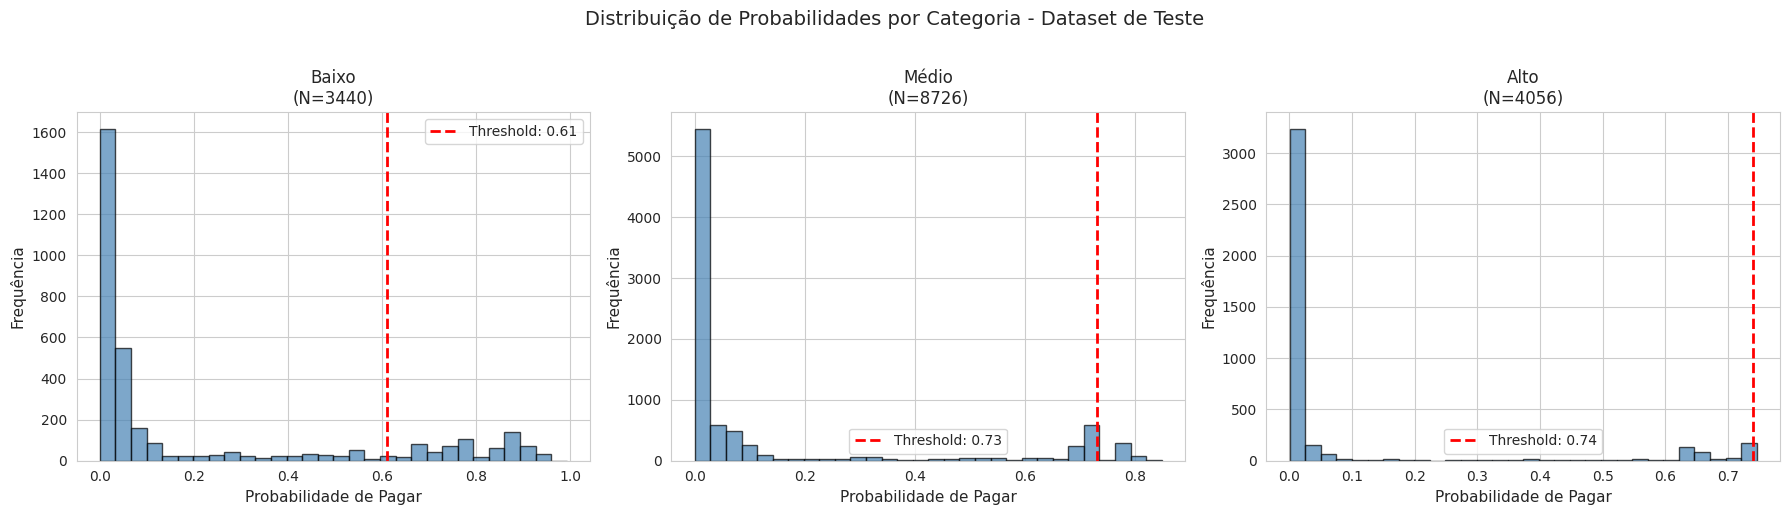


✅ Gráfico salvo em: v3_runs/run_20251127_144539/distribuicao_probabilidades_teste.png


In [64]:
# ==============================================================================
# 15. GRÁFICOS CONSOLIDADOS DAS PREDIÇÕES
# ==============================================================================

if test_results:
    fig, axes = plt.subplots(1, len(test_results), figsize=(6*len(test_results), 5))
    
    if len(test_results) == 1:
        axes = [axes]
    
    for ax, r in zip(axes, test_results):
        # Histograma de probabilidades
        ax.hist(r['y_proba'], bins=30, edgecolor='black', alpha=0.7, color='steelblue')
        ax.axvline(x=r['threshold'], color='red', linestyle='--', linewidth=2, 
                   label=f'Threshold: {r["threshold"]:.2f}')
        ax.set_xlabel('Probabilidade de Pagar', fontsize=11)
        ax.set_ylabel('Frequência', fontsize=11)
        ax.set_title(f'{r["categoria"]}\n(N={r["total"]})', fontsize=12)
        ax.legend(fontsize=10)
    
    plt.suptitle('Distribuição de Probabilidades por Categoria - Dataset de Teste', fontsize=14, y=1.02)
    plt.tight_layout()
    plt.savefig(BASE_OUTPUT_DIR / "distribuicao_probabilidades_teste.png", dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"\n✅ Gráfico salvo em: {BASE_OUTPUT_DIR / 'distribuicao_probabilidades_teste.png'}")

In [65]:
# ==============================================================================
# 16. CONSOLIDAÇÃO FINAL - TODAS AS PREDIÇÕES
# ==============================================================================

if test_results:
    print("\n" + "=" * 80)
    print("📦 CONSOLIDANDO TODAS AS PREDIÇÕES")
    print("=" * 80)
    
    # Concatena todos os resultados
    all_predictions = []
    for r in test_results:
        df_pred = r['df_resultado'].copy()
        all_predictions.append(df_pred)
    
    df_all_predictions = pd.concat(all_predictions, ignore_index=True)
    
    # Salva arquivo consolidado
    consolidated_file = BASE_OUTPUT_DIR / "TODAS_PREDICOES_TESTE.csv"
    df_all_predictions.to_csv(consolidated_file, sep=';', index=False, decimal=',')
    
    print(f"\n>>> Total de predições consolidadas: {len(df_all_predictions)}")
    print(f">>> Arquivo salvo: {consolidated_file}")
    
    # Estatísticas finais
    print("\n📊 ESTATÍSTICAS FINAIS:")
    print(f"   Total de clientes analisados: {len(df_all_predictions)}")
    protestar_total = (df_all_predictions['decisao_protesto'] == 1).sum()
    nao_protestar_total = (df_all_predictions['decisao_protesto'] == 0).sum()
    print(f"   Decisão PROTESTAR: {protestar_total} ({protestar_total/len(df_all_predictions):.1%})")
    print(f"   Decisão NÃO Protestar: {nao_protestar_total} ({nao_protestar_total/len(df_all_predictions):.1%})")
    
    print("\n   Por categoria:")
    for cat in df_all_predictions['categoria_risco_score'].unique():
        df_cat = df_all_predictions[df_all_predictions['categoria_risco_score'] == cat]
        prot = (df_cat['decisao_protesto'] == 1).sum()
        print(f"      {cat}: {len(df_cat)} clientes, {prot} ({prot/len(df_cat):.1%}) para protestar")


📦 CONSOLIDANDO TODAS AS PREDIÇÕES

>>> Total de predições consolidadas: 16222
>>> Arquivo salvo: v3_runs/run_20251127_144539/TODAS_PREDICOES_TESTE.csv

📊 ESTATÍSTICAS FINAIS:
   Total de clientes analisados: 16222
   Decisão PROTESTAR: 1064 (6.6%)
   Decisão NÃO Protestar: 15158 (93.4%)

   Por categoria:
      Baixo: 3440 clientes, 661 (19.2%) para protestar
      Médio: 8726 clientes, 402 (4.6%) para protestar
      Alto: 4056 clientes, 1 (0.0%) para protestar


In [66]:
# ==============================================================================
# 17. RESUMO FINAL E INSTRUÇÕES
# ==============================================================================

print("\n" + "=" * 80)
print("✅ EXECUÇÃO CONCLUÍDA COM SUCESSO!")
print("=" * 80)

print(f"\n📂 DIRETÓRIO DE SAÍDA: {BASE_OUTPUT_DIR}")
print("\n📁 ESTRUTURA DE ARQUIVOS GERADOS:")
print(f"""
{BASE_OUTPUT_DIR}/
├── RESUMO_GERAL.md              # Resumo de todos os modelos
├── RELATORIO_TESTE.md           # Relatório das predições no teste
├── resumo_treinamento.csv       # Tabela de métricas
├── distribuicao_probabilidades_teste.png
├── TODAS_PREDICOES_TESTE.csv    # Predições consolidadas
│
├── baixo/                       # (se treinado)
│   ├── modelo_Baixo.joblib
│   ├── relatorio_metricas_Baixo.txt
│   ├── predicoes_teste_Baixo.csv
│   ├── analise_threshold_Baixo.csv
│   ├── matriz_confusao_Baixo.png
│   ├── precision_recall_Baixo.png
│   └── distribuicao_probabilidades_Baixo.png
│
├── medio/                       # (se treinado)
│   └── ... (mesmos arquivos)
│
└── alto/                        # (se treinado)
    └── ... (mesmos arquivos)
""")

print("\n🎯 COMO USAR OS MODELOS:")
print("""
# Carregar modelo treinado
import joblib

model_data = joblib.load('v3_runs/run_XXXXXXXX/baixo/modelo_Baixo.joblib')

pipeline = model_data['pipeline']
threshold = model_data['optimal_threshold']
features = model_data['features']

# Fazer predições
X_new = df_novos_dados[features]
probabilidades = pipeline.predict_proba(X_new)[:, 1]
decisoes = (probabilidades >= threshold).astype(int)
""")

print("\n" + "=" * 80)
print("🏆 FIM DO NOTEBOOK - ML PROTESTO V3")
print("=" * 80)


✅ EXECUÇÃO CONCLUÍDA COM SUCESSO!

📂 DIRETÓRIO DE SAÍDA: v3_runs/run_20251127_144539

📁 ESTRUTURA DE ARQUIVOS GERADOS:

v3_runs/run_20251127_144539/
├── RESUMO_GERAL.md              # Resumo de todos os modelos
├── RELATORIO_TESTE.md           # Relatório das predições no teste
├── resumo_treinamento.csv       # Tabela de métricas
├── distribuicao_probabilidades_teste.png
├── TODAS_PREDICOES_TESTE.csv    # Predições consolidadas
│
├── baixo/                       # (se treinado)
│   ├── modelo_Baixo.joblib
│   ├── relatorio_metricas_Baixo.txt
│   ├── predicoes_teste_Baixo.csv
│   ├── analise_threshold_Baixo.csv
│   ├── matriz_confusao_Baixo.png
│   ├── precision_recall_Baixo.png
│   └── distribuicao_probabilidades_Baixo.png
│
├── medio/                       # (se treinado)
│   └── ... (mesmos arquivos)
│
└── alto/                        # (se treinado)
    └── ... (mesmos arquivos)


🎯 COMO USAR OS MODELOS:

# Carregar modelo treinado
import joblib

model_data = joblib.load('v3_runs/